# Parkrun twitter analysis

Jenny Woods May 2020

Code to carry out natural language processing (NLP) and topic modelling on tweets with #parkrun hashtag.

Using *tweepy* to grab tweets, *spaCy* and *NLTK* for NLP, and *gensim*'s LDA (Latent Dirichlet Allocation) model for topic modelling.

#### Import libraries

In [1]:
import pandas as pd
import geopandas
import pycountry
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(font_scale=1.2)
%matplotlib inline

import tweepy

import re
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
#nltk.download()
nltk.data.path = ['/home/jenny/sw/nltk_data']
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
import wordsegment
wordsegment.load()
import gensim

import multiprocessing as mp

#### Functions to read and write df to pickle

In [18]:
def write_pkl(fname, df):
    with open(fname,'wb') as pklf:
        pickle.dump((df), pklf)
        print('Saved to', fname)
        
def read_pkl(fname):
    with open(fname,'rb') as pklf:
        df = pickle.load(pklf)
    return df

#### Twitter API authentication

API authentication keys are required to grab tweets.

My twitter developer acc auth details are stored in and extracted from file *twitterAPIauth_keys*

In [19]:
with open('../twitterAPIauth_keys', 'r') as f:
    twitterAPIauth_keys = json.load(f)
    
consumer_key = twitterAPIauth_keys['consumer_key']
consumer_secret = twitterAPIauth_keys['consumer_secret']
access_token = twitterAPIauth_keys['access_token']
access_token_secret = twitterAPIauth_keys['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

## Tweets with #parkrun hashtag

Using tweepy api.search here. See http://docs.tweepy.org/en/latest/api.html for other tweepy classes. Eg to grab home timeline, use api.home_timeline:

        for tweet in api.home_timeline() :
            print(tweet.text)


### Grab tweets and write dataframe to pickle

api.search grabs tweets in the last 6-9 days - premium search APIs *or* known tweet IDs required for grabbing tweets further back in time

In [20]:
today = pd.Timestamp.today().date()

tweets=[]
for tweet in tweepy.Cursor(api.search,
                           q="#parkrun",
                           tweet_mode='extended',
                           lang="en").items():

    #print(tweet) # view full tweet to explore other attributes

    try :
        text = str(tweet.retweeted_status.full_text)
        tweet_type = 'Retweet'
    except AttributeError:
        text = str(tweet.full_text)
        tweet_type = 'Tweet'

    # Decode and remove symbols
    text = text.encode('ascii',errors='ignore').decode('UTF-8')
    text = text.replace('&amp;', 'and') # remove &amp;
        
    try :
        location = tweet.place.name+', '+tweet.place.country
        # convert country code from 2- to 3-letter with Pycountry
        isoa2 = tweet.place.country_code
        country_code = pycountry.countries.get(alpha_2=isoa2).alpha_3 
    except:
        location = ''
        country_code = ''
    
    tweets.append({"datetime": tweet.created_at,
                   #"id": tweet.id,
                   "location": location,
                   "country_code": country_code,
                   "text": text,
                   "tweet_type": tweet_type,
                   "user_handle": tweet.user.screen_name,
                   #"user_id": tweet.user.id,
                   "user_location": tweet.user.location,
                  })

tweets_df = pd.DataFrame(tweets)
print(len(tweets_df),'tweets grabbed\n')

fname = 'parkrun_tweets_downloaded'+str(today)+'.pkl'
write_pkl('data/'+fname, tweets_df)

514 tweets grabbed

Saved to data/parkrun_tweets_downloaded2020-05-10.pkl


### OR, read tweets from pickle

In [21]:
fname = 'parkrun_tweets_downloaded2020-05-10.pkl'

tweets_df = read_pkl('data/'+fname)
tweets_df.head(10)

,country_code,datetime,location,text,tweet_type,user_handle,user_location
0,,2020-05-10 17:20:52,,Great episode of @CheerfulPodcast especially t...,Tweet,markhillary,"São Paulo, Brasil"
1,,2020-05-10 14:17:11,,@wynneevans @parkrunUK @cardiffparkrun I know ...,Tweet,donnalovely31,"Leeds, England"
2,,2020-05-10 13:40:50,,This week's 'virtual' parkrun results are now ...,Tweet,Maldonparkrun,"Promenade Park, Maldon, Essex"
3,,2020-05-10 13:15:10,,My fellow parkrunner Daniel Schrade composed a...,Retweet,bviteritti,"Esslingen am Neckar, BW, DE"
4,,2020-05-10 13:08:30,,Instead of running the Richmond Ranelagh Half ...,Retweet,CWElliot,"North West, England"
5,,2020-05-10 12:47:25,,Instead of running the Richmond Ranelagh Half ...,Tweet,KateChhatwal,"London, UK"
6,,2020-05-10 12:27:03,,My fellow parkrunner Daniel Schrade composed a...,Tweet,RunswithaCoypu,
7,,2020-05-10 12:23:30,,NEW YOUTUBE VIDEO!!\n\nAre you resting? Using ...,Retweet,Nizaamudien,cpt
8,GBR,2020-05-10 12:08:40,"Witney, United Kingdom",I was so close to my 50th #parkrun and then we...,Tweet,MrsO_92,United Kingdom
9,,2020-05-10 11:46:04,,Not a Virtual #Parkrun Plus (as we tail walked...,Tweet,Keiron,Swindon


### Let's take a look at when people tweet about parkrun

Unsurprisingly (even in lockdown)... it's mostly Saturday!

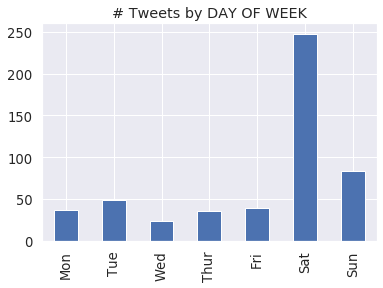

In [22]:
#ax = tweets_df['datetime'].apply(lambda x : str(x.date())).value_counts().sort_index().plot.bar()
#ax.set_title('# Tweets by DATE')

ax = tweets_df['datetime'].apply(lambda x : str(x.weekday())).value_counts().sort_index().plot.bar()
ax.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
ax.set_title('# Tweets by DAY OF WEEK')
plt.show()

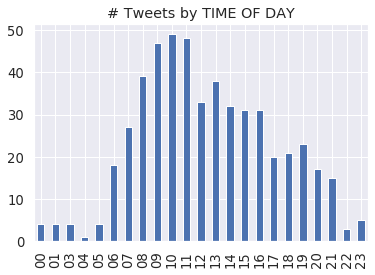

In [23]:
ax = tweets_df['datetime'].apply(lambda x : str(x.time())[0:2]).value_counts().sort_index().plot.bar()
ax.set_title('# Tweets by TIME OF DAY')
plt.show()

### Who are the biggest #parkrun Tweeters this week?

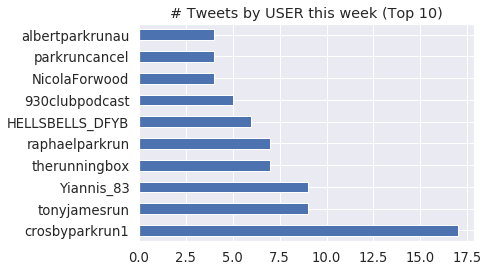

In [24]:
ax = tweets_df['user_handle'].value_counts()[0:10].plot.barh()
ax.set_title('# Tweets by USER this week (Top 10)')
plt.show()

### Which hashtags were used most this week with #parkrun?

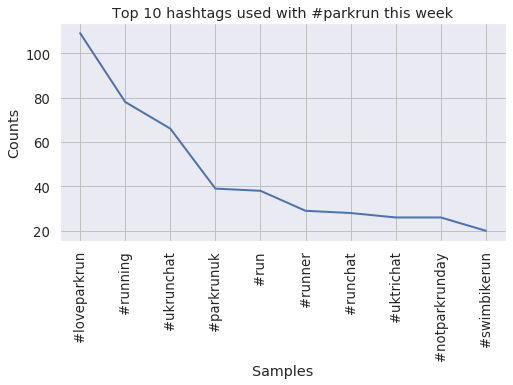

In [25]:
def grab_hashtags(text):
    
    hashtags=[]
    for word in text.split():
        if word[0:1] == '#' and word.lower() != '#parkrun':
            hashtags.append(word)
    
    return hashtags

tweets_df['hashtags'] = tweets_df['text'].apply(lambda x: grab_hashtags(x))

hashtag_freq = nltk.FreqDist(pd.Series([hashtag for row in tweets_df['hashtags'] for hashtag in row]).values)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = hashtag_freq.plot(10, cumulative=False, title='Top 10 hashtags used with #parkrun this week')
plt.show()

### Where were people tweeting?

Import geopandas world dataset and plot countries coloured by number of #parkrun tweets in the last week.

Note not all twitter users allow geo-location - only about 10% of tweets in this dataset are geolocated.

In [40]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world['n_parkrun_tweets'] = 0
for country, count in tweets_df['country_code'].value_counts().items() :
    if country :
        print(count,'tweets from',country)
        indx = world.index[world['iso_a3'] == country]
        world['n_parkrun_tweets'].loc[indx] = count

53 tweets from GBR
5 tweets from IRL
1 tweets from ZAF
1 tweets from AUS


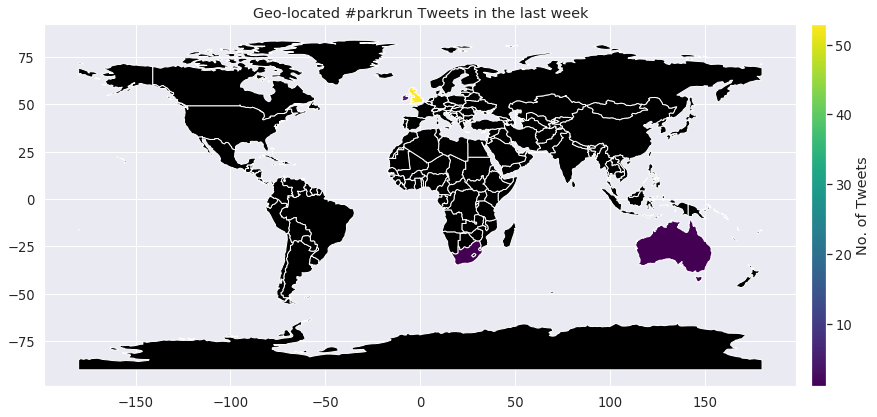

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

# plot all countries in black
world.plot(ax=ax, color='black')
# overlay countries with #parkrun tweets, colored by number of tweets
world_tweets = world[world['n_parkrun_tweets'] != 0]
world_tweets.plot(column='n_parkrun_tweets',
                  legend=True, legend_kwds={'label': "No. of Tweets", 'orientation': "vertical"},
                  ax=ax, cax=cax,
                  cmap='viridis')

ax.set_title('Geo-located #parkrun Tweets in the last week')
plt.show()

## Natural language processing

Process the tweet text content for topic modelling.

Using spaCy, wordsegment and - if stemming - nltk

* **Segment hashtags and twitter handles**

* **Remove special characters, punctuation, spaces, integer tokens and web addresses**

* **Lemmatize** (group together inflected forms of a word so they can be analysed as a single item)

* **Remove stopwords** (eg is, the, a - so that more focus can be given to those words which define the meaning of the text)

* *Stem (reduce words to root form)*

#### Function to process (clean and tokenize) the text for topic modelling

In [18]:
def NLP_prep(text):
    
    # make lowercase, remove newlines
    text = text.lower().replace('\n',' ')    
    
    firstfilt=[]
    for word in text.split():
        # separate handles and hashtags into individual words (and in doing so remove #/@)
        if word[0:1] == '#' or word[0:1] == '@' :
            firstfilt.append(' '.join(wordsegment.segment(word)))
        else :
            # ignore web addresses (or at least those beginning http or www)
            if word[0:4] != 'http' and word[0:3] != 'www' and not re.search('androidappwhatsapp', word):
                firstfilt.append(word)
    text = ' '.join(firstfilt)
    
    # remove digits and various symbols
    text = re.sub('[0-9_:;.,()%$~!?\+=><^`\*]+', '', text)
    
    # replace forward slash and amphersand
    text = text.replace('/',' ').replace('&',' ').replace('&amp;', ' ')
    
    doc = nlp(text)  # Using spaCy
    tokens = []
    filtered_tokens = []
    for token in doc:
        if not token.is_punct | token.is_space : # ignore punctuation and spaces
            
            # LEMMATIZE
            tokens.append(token.lemma_ if token.lemma_ != '-PRON-' else token.lower_)

    for token in tokens:
        lexeme = nlp.vocab[token]
        # ignore STOPWORDS (incl. topic-specific stopwords, like park run uk) and words less than 3 characters
        if lexeme.is_stop == False and token not in ['park','run','parkrun','uk'] and len(token) > 2 :
            filtered_tokens.append(token)
            #filtered_tokens.append(stemmer.stem(token)) # Take stem of words using nltk
                    
    return filtered_tokens

Example of processing a tweet

In [19]:
text = tweets_df['text'].iloc[1]
print('BEFORE preprocessing:\n================\n')
print(text,'\n')

filtered_tokens = NLP_prep(text)
print('AFTER preprocessing:\n================\n')
print(' '.join(filtered_tokens))

BEFORE preprocessing:

Missing #parkrun but now that we can go out 6-9 every Saturday now I'll wear a milestone tshirt and go walking. Reminding myself and others we WILL be back https://t.co/TmXR3REv2B 

AFTER preprocessing:

miss saturday wear milestone tshirt walk remind


#### Clean and tokenize the tweets

In [20]:
tweets_df['processed text'] = tweets_df['text'].apply(lambda x: NLP_prep(x))
tweets_df[tweets_df['tweet_type'] == 'Tweet'].head(10) # just tweets

,datetime,location,text,tweet_type,user_handle,user_location,hashtags,processed text
0,2020-05-09 17:55:25,,Not your everyday running obstruction #tonyja...,Tweet,tonyjamesrun,"North West, England","[#tonyjamesrunning, #londonmarathon, #marathon...","[everyday, obstruction, tony, james, london, m..."
1,2020-05-09 17:53:50,,Missing #parkrun but now that we can go out 6-...,Tweet,Diane80499280,South Africa,[],"[miss, saturday, wear, milestone, tshirt, walk..."
4,2020-05-09 17:28:28,,Run report and results from virtual non-parkru...,Tweet,sligoparkrun,"Sligo, Ireland",[#4],"[report, result, virtual, non, -may-, news, sl..."
6,2020-05-09 17:24:15,"Canterbury, United Kingdom",In times like this we need to dig deep within ...,Tweet,Yiannis_83,"Canterbury, England","[#uktrichat, #ukrunchat, #runchat]","[time, like, need, dig, deep, strength, order,..."
7,2020-05-09 16:37:33,,Love my new #parkrun top even though I wore it...,Tweet,Rlou31752486,"England, United Kingdom",[],"[love, new, wear, cycle, today, terrible, phot..."
10,2020-05-09 16:24:02,,Definitely NOT leading by example. Set off ful...,Tweet,runningjo10k,,[],"[definitely, lead, example, set, overconfidenc..."
11,2020-05-09 16:21:13,,I miss my parkrun family \n#parkrun #COVID19,Tweet,alexhorgsn_alex,,[#COVID19],"[miss, family, covid]"
13,2020-05-09 16:13:08,"Liverpool, United Kingdom",Another event another rainbow of tops Purple ...,Tweet,crosbyparkrun1,"Crosby, England","[#crosbyparkrun, #crosby, #parkrunuk, #lovepar...","[event, rainbow, purple, hard, find, week, pho..."
15,2020-05-09 16:03:20,,Had to avoid a cow blocking my path on my @par...,Tweet,parkrunrocks,,[#missing],"[avoid, cow, block, path, rock, today, normall..."
16,2020-05-09 15:58:29,,Great to see parkrunners starting to use #park...,Tweet,parkrunrocks,,"[#parkrunrocks, #missing]","[great, parkrunner, start, use, rock, miss]"


### Take a look at simple word frequency distribution

Looking here at Tweets *and* Retweets.

To use tweets only, add following code to split dataframe into tweets df and retweets df.

    # split dataframe into tweets df and retweets df
    retweets_df = tweets_df[tweets_df['tweet_type'] == 'Retweet']
    tweets_df = tweets_df[tweets_df['tweet_type'] == 'Tweet']

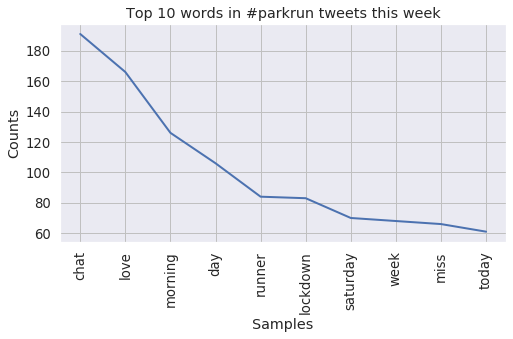

In [27]:
# concatenate words from all tweets
alltokens = [token for row in tweets_df['processed text'] for token in row]
alltokens = pd.Series(alltokens)

freq = nltk.FreqDist(alltokens.values)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = freq.plot(10, cumulative=False, title='Top 10 words in #parkrun tweets this week')
plt.show()

#### Lexical diversity

(i.e. ratio of unique tokens to the total number of tokens)

In [79]:
float(len(set(alltokens)))/float(len(alltokens))

0.22159870308018456

Words longer than 8 characters occuring more than 10 times

In [80]:
vocab = freq.keys()

freqwords = [(w,freq[w]) for w in vocab if len(w) > 8 and freq[w] > 10]
sorted(freqwords, key=lambda tup: tup[0])

[('anniversary', 20),
 ('beautiful', 18),
 ('challenge', 36),
 ('community', 15),
 ('coronavirus', 12),
 ('distancing', 19),
 ('motivated', 12),
 ('motivation', 25),
 ('subscribe', 11),
 ('volunteer', 25),
 ('yesterday', 16)]

#### Most common parts of speech

We see that #parkrun tweets contain many nouns (NN) and adjectives (JJ), and to a lesser extent verbs (VBP, VB) and adverbs (RB)

In [81]:
tag_fd = nltk.FreqDist(tag for (word, tag) in nltk.pos_tag(alltokens.values))
tag_fd.most_common(5)

[('NN', 4352), ('JJ', 1761), ('VBP', 384), ('RB', 347), ('VB', 200)]

## Topic Modelling

Using Gensim's LDA (Latent Dirichlet Allocation) model.

#### Create bag of words

In [30]:
dictionary = gensim.corpora.Dictionary(tweets_df['processed text'])

## Filter out uncommon words - can only do this when have a lot of data
#print('n words:',len(dictionary))
#dictionary.filter_extremes(no_below=2, no_above=0.5)
#print('n post-filter:',len(dictionary))

# For each tweet create a dictionary of words and word freq
bow_corpus = [dictionary.doc2bow(tweet) for tweet in tweets_df['processed text']]

### Create LDA model

Note this is computationally expensive if using a large number of tweets.

Here we're only looking at a weeks-worth, so the topic modelling below is mainly for demo purposes (not enough data!)

In [33]:
ncores = mp.cpu_count()-1 # use all but one core
ntopics = 6
#ntopics = 20

In [127]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=ntopics, id2word=dictionary,
                                       passes=10, workers=ncores)

In [128]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"chat" + 0.026*"love" + 0.012*"stay" + 0.012*"crosby" + 0.011*"new" + 0.011*"day" + 0.011*"today" + 0.010*"week" + 0.010*"channel" + 0.008*"great"
Topic: 1 
Words: 0.045*"chat" + 0.021*"marathon" + 0.021*"runner" + 0.017*"love" + 0.013*"day" + 0.012*"running" + 0.012*"new" + 0.012*"bike" + 0.011*"london" + 0.010*"swim"
Topic: 2 
Words: 0.014*"runner" + 0.013*"saturday" + 0.012*"week" + 0.011*"love" + 0.010*"day" + 0.008*"good" + 0.008*"challenge" + 0.008*"chat" + 0.007*"morning" + 0.007*"friend"
Topic: 3 
Words: 0.027*"morning" + 0.018*"day" + 0.016*"saturday" + 0.016*"virtual" + 0.015*"like" + 0.015*"chat" + 0.015*"love" + 0.012*"good" + 0.011*"miss" + 0.011*"feel"
Topic: 4 
Words: 0.026*"morning" + 0.020*"love" + 0.020*"miss" + 0.014*"crosby" + 0.013*"photo" + 0.012*"suffolk" + 0.012*"time" + 0.011*"month" + 0.009*"chat" + 0.009*"day"
Topic: 5 
Words: 0.018*"lockdown" + 0.017*"house" + 0.015*"bantock" + 0.014*"old" + 0.012*"blue" + 0.010*"love" + 0.010*"anniver

In [129]:
write_pkl('models/'+fname[:-4]+'_LDAmodel.pkl', lda_model)

Saved to models/parkrun_tweets_downloaded2020-05-09_LDAmodel.pkl


### Run analysis of tweets based on LDA model

In [28]:
try :
    lda_model
except :
    lda_model = read_pkl('models/'+fname[:-4]+'_LDAmodel.pkl')

#### Identify best match topic for each twitter user

In [31]:
topic_all = []
score_all = []
topic_l = {}
score_l = {}
for iname in tweets_df["user_handle"].unique():
    topic_l[iname] = []
    score_l[iname] = []

for itweet in np.arange(len(tweets_df)):
    index_and_score = sorted(lda_model[bow_corpus[itweet]], key=lambda tup: -1*tup[1])[0]
    topic_all.append(index_and_score[0])
    score_all.append(index_and_score[1])
    sender = tweets_df["user_handle"].iloc[itweet]
    topic_l[sender].append(index_and_score[0])
    score_l[sender].append(index_and_score[1])

In [34]:
## Mapping to sorted topics by frequency of appearence  
hist,edges = np.histogram(topic_all, bins=ntopics, range=[0,ntopics], density=True)
sorter = np.argsort(-hist)

# Create topic labels in appropriate order
topic_labels = {}
for i in np.arange(ntopics):
    words = lda_model.show_topic(i,6)
    ii = sorter[i]
    topic_labels[ii] = words[0][0]+"/"+words[1][0]+"/"+words[2][0]

### Plot conversation topics

In [35]:
#list(topic_l.keys()) # list user handles
user_handle = 'crosbyparkrun1' # top tweeter this week!

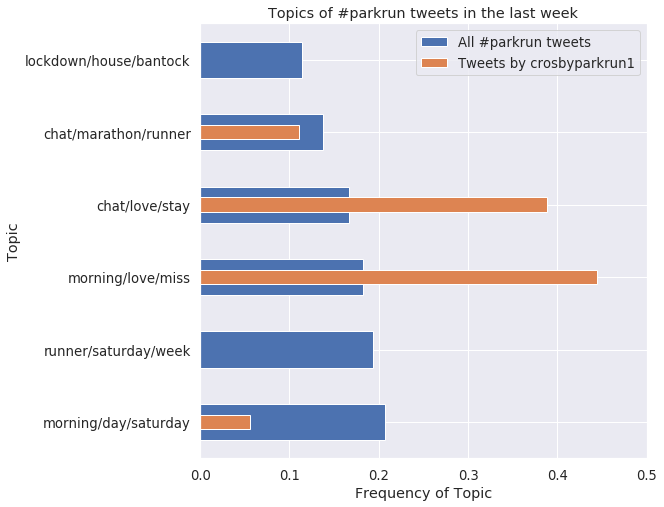

In [37]:
hist_user,edges_user = np.histogram(topic_l[user_handle], bins=ntopics, range=[0,ntopics], density=True)
            
plt.figure(figsize=(8,8))
#plt.subplot(121)
plt.axis([0,0.5,-0.5,5.5])
ind = [i for i in range(0,ntopics)]
plt.barh(ind,hist[sorter],height=0.5,label="All #parkrun tweets")
plt.barh(sorter,hist_user,height=0.2,label="Tweets by "+user_handle)
plt.yticks(ind,\
    [topic_labels[0],topic_labels[1],topic_labels[2],topic_labels[3],topic_labels[4],
    topic_labels[5]])
plt.ylabel("Topic")
plt.xlabel("Frequency of Topic")
plt.title('Topics of #parkrun tweets in the last week')
plt.legend(loc=1)

plt.show()